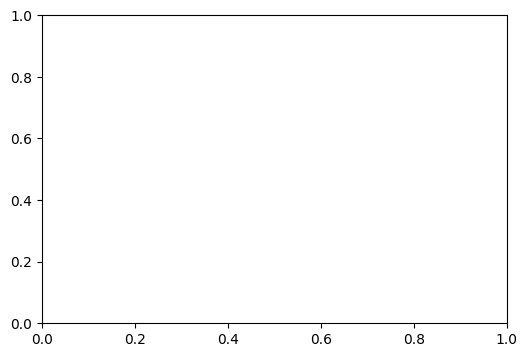

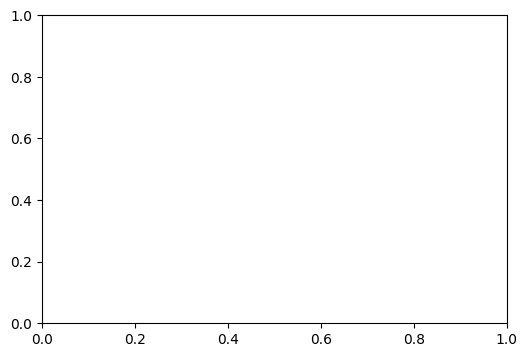

In [1]:
import gui
import tkinter as tk

2500 2500 2500
#points: 2500(2500)
GENERATE FUNCTION: Simple CCPD
Area size: 100.0|100.0
Variable: 20.0
DURATION: 0.9321162700653076 sec
---------------------------------------------------------------------


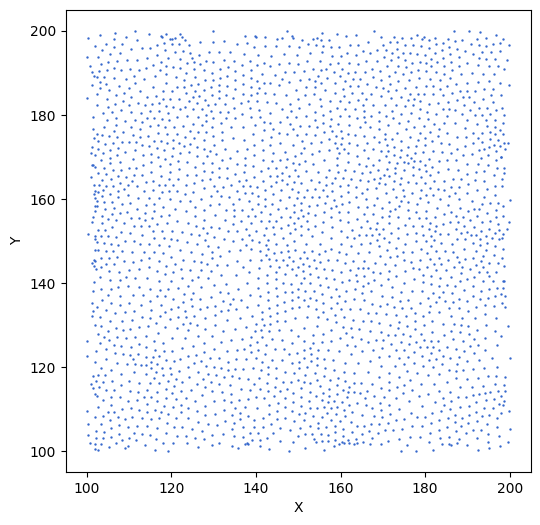

In [2]:
if __name__ == "__main__":
    root = tk.Tk()
    app = gui.GUIApp(root)
    root.mainloop()

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Delaunay
#TODO read points with hole, read points generated, union and 

def load_2d(path):
    # Read point cloud data from file
    with open(path, 'r') as file:
        num_points = int(file.readline().strip())
        points = []
        for line in file:
            a, b = map(float, line.strip().split())
            points.append([a,b])

    # Convert data to numpy arrays
    return points

#load points from file
def load(path):
    # Read point cloud data from file
    with open(path, 'r') as file:
        first_line = file.readline().strip()
        if first_line.count(" ") > 1 and first_line.count(".") > 1:
            file.close
            file = open(path, 'r')

        x, y, z = [], [], []
        for line in file:
            a, b, c = map(float, line.strip().split())
            x.append(a)
            y.append(b)
            z.append(c)

    # Convert data to numpy arrays
    return np.array([x, y, z]).T

def show(points, title="Graph", figsize=(10, 6)):
    plt.ion()  # Enable interactive mode
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,2], cmap='viridis', marker='o', s=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)

    plt.draw()  # Redraw the current figure
    plt.pause(0.1)  # Pause briefly to ensure the plot is updated
    
def show_2d(points_2d, color="blue", size=0.3, ax=None, title="2D plot", figsize=(10, 6)):
    points_2d = np.array(points_2d)
    isCalledNormaly = True
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        isCalledNormaly = False
    ax.scatter(points_2d[:, 0], points_2d[:, 1], s=size, c=color)

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    if isCalledNormaly:
        plt.show()

def addToPlot(ax, points_2d, color="green", size=0.5):
    ax.scatter(points_2d[:, 0], points_2d[:, 1], s=size, c=color)

def showAndAdd_2d(points1, points2, color="blue", size=0.3, title="2D plot", figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    show_2d(points1, color, size, ax, title)
    addToPlot(ax, np.array(points2), "red", 0.3)

    plt.show()
        

In [2]:
from shapely.geometry import Polygon

def triangulate(points, figsize=(8,6), title="triangles"):
    points=np.array(points)
    # Provedení Delaunay triangulace
    triangulation = Delaunay(points)

    # Výsledná trojúhelníková síť
    triangles = points[triangulation.simplices]

    # Vytvoření objektu Polygon pro každý trojúhelník
    polygons = [Polygon(triangle) for triangle in triangles]

    # Výpočet průměrné plochy
    average_area = np.mean([polygon.area for polygon in polygons])

    # Kontrola a výběr trojúhelníků s plochou větší než TRIANGLE_SIZE_THRESHOLD * průměrná plocha
    selected_triangles = []
    for i, polygon in enumerate(polygons):
        if polygon.area > 0.1 * average_area:
            selected_triangles.append(triangles[i])
    
    
    triangle_areas = []
    for tri in triangles:
        triangle_area = 0.5 * np.abs(np.cross(tri[1] - tri[0], tri[2] - tri[0]))
        triangle_areas.append(triangle_area)
    largest_indices = np.argsort(triangle_areas)[-5:]
    fig, ax = plt.subplots(figsize = figsize)   
    for tri in triangles:
        triangle_points = tri[0], tri[1], tri[2]
        ax.plot(*zip(*np.vstack((triangle_points, triangle_points[0]))), color="blue", linewidth=0.5)
    # Highlight the five largest triangles
    for idx in largest_indices:
        tri = triangles[idx]
        triangle_points = tri[0], tri[1], tri[2]
        ax.plot(*zip(*np.vstack((triangle_points, triangle_points[0]))), color="red", linewidth=2)
    
    # Set axis labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    
    plt.show()



20000


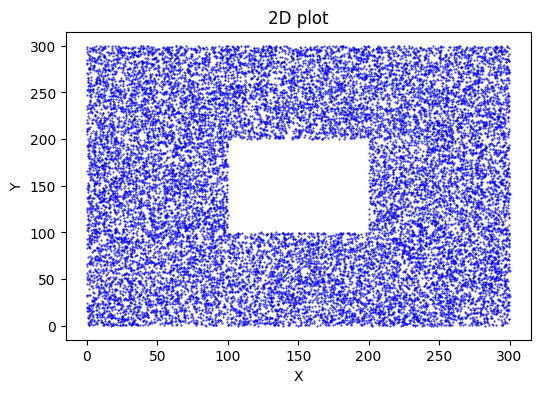

In [3]:
wid = 300
hei = 300
n = 20000
hole = [100,100,200,200]
points=[]
for i in range(n):
    p = [random.random()*wid,random.random()*hei]
    while (p[0]>hole[0] and p[0]<hole[2] and p[1]>hole[1] and p[1]<hole[3]):
        p = [random.random()*wid,random.random()*hei]
    points.append(p)
print(len(points))
show_2d(points, figsize=(6,4), size=0.2)



In [4]:
from scipy.interpolate import LinearNDInterpolator

#takes points and mesh of the old geometry and interpolates new points 
#param: old geometry structure, new repaired 2D points
#ret: repaired points describing old geometry
def move_points_to_surface(surface_points_3d, plane_points_2d):
    # Triangulate the surface points
    tri = Delaunay(surface_points_3d[:, :2])
    
    # Create an interpolator for the Z coordinate
    interpolator = LinearNDInterpolator(tri, surface_points_3d[:, 2])
    
    # Add a Z coordinate to the plane points
    plane_points_3d = np.zeros((plane_points_2d.shape[0], 3))
    plane_points_3d[:, :2] = plane_points_2d
    plane_points_3d[:, 2] = interpolator(plane_points_2d)
    
    return plane_points_3d


#move points so they are in best fit plane
def project_points_onto_plane(points, normal):
    # Normalize the normal vector
    normalized_normal = normal / np.linalg.norm(normal)
    # Compute the projection matrix
    projection_matrix = np.eye(3) - np.outer(normalized_normal, normalized_normal)
    # Project the points onto the plane
    projected_points = points @ projection_matrix
    return projected_points


#get corner points of set for fit plane construction
#param: set of points
#ret: corner points
def getPointsForPlaneConstruction(criticalPoints):
    resultX, resultY, resultZ = list(), list(), list()
    minP = [float('inf'), float('inf'), 0]
    maxP = [-float('inf'), -float('inf'), 0]
    minMaxP = criticalPoints[0]
    maxMinP = criticalPoints[0]

    for p in criticalPoints:
        if minP[0] + minP[1] > p[0] + p[1]:
            minP = p
        if maxP[0] + maxP[1] < p[0] + p[1]:
            maxP = p
        xDiff1 = minMaxP[0] - p[0]
        yDiff1 = p[1] - minMaxP[1]
        if xDiff1 + yDiff1 > 0:
            minMaxP = p
        xDiff2 = p[0] - maxMinP[0]
        yDiff2 = maxMinP[1] -  p[1]
        if xDiff2 + yDiff2 > 0:
            maxMinP = p
        
    resultX.append(minP[0])
    resultX.append(maxP[0])
    resultX.append(minMaxP[0])
    resultX.append(maxMinP[0])
    resultY.append(minP[1])
    resultY.append(maxP[1])
    resultY.append(minMaxP[1])
    resultY.append(maxMinP[1])
    resultZ.append(minP[2])
    resultZ.append(maxP[2])
    resultZ.append(minMaxP[2])
    resultZ.append(maxMinP[2])
    result = np.array([resultX, resultY, resultZ]).T
    return result


#get fit plane and return its normal vector
#param: set of points in question
#ret: normal vector of those points
def getNormalOfBestFitPlane(criticalPoints):
    points = getPointsForPlaneConstruction(criticalPoints)
    # Ensure points is a NumPy array
    points = np.array(points)
    # Centroid of the points
    centroid = np.mean(points, axis=0)
    # Subtract the centroid to center the points
    centered_points = points - centroid
    # Use Singular Value Decomposition (SVD)
    _, _, v = np.linalg.svd(centered_points)
    # The normal vector of the plane is the last column of v
    normal_vector = v[-1, :]
    return normal_vector


#project points into best fit plane making them 2D with minimized error and rotate that plane into x,y with all points having z=0
def projectPoints(criticalPoints):
    #find the best fit plane for given points
    planeNormalVector = getNormalOfBestFitPlane(criticalPoints)    
    
    resultPoints = project_points_onto_plane(criticalPoints, planeNormalVector)
    return resultPoints


def flatten_points(nested_points):
    # Flatten the nested list if necessary
    while(True):
        if len(nested_points) == 1 and isinstance(nested_points[0], list):
            nested_points = nested_points[0]
        return nested_points


In [5]:
def mergeWithHole(pts, setName):
    points = load("../Diplomka/SOLUTION/custom4.txt")
    #show(points)
    normal = getNormalOfBestFitPlane(points)
    planePoints = project_points_onto_plane(points, [0,0,1])
    #hole: if a < 0.45 or a > 0.55 or b < 0.45 or b > 0.55:
    # Function to rescale points from [100, 200] to [0.45, 0.55]
    def rescale_points(points, old_min, old_max, new_min, new_max):
        scale = (new_max - new_min) / (old_max - old_min)
        new_points = new_min + (points - old_min) * scale
        return new_points

    # Rescale x and y coordinates separately
    new_x_min, new_x_max = 0.45, 0.55
    new_y_min, new_y_max = 0.45, 0.55
    old_x_min, old_x_max = 100, 200
    old_y_min, old_y_max = 100, 200

    patchPoints = flatten_points(np.array(pts.copy()).reshape(len(pts[0]),2))
    rescaled_points = np.zeros_like(patchPoints)
    rescaled_points[:, 0] = rescale_points(patchPoints[:, 0], old_x_min, old_x_max, new_x_min, new_x_max)
    rescaled_points[:, 1] = rescale_points(patchPoints[:, 1], old_y_min, old_y_max, new_y_min, new_y_max)

    planePoints = planePoints[:, :2]
    #show_2d(rescaled_points)
    #show_2d(planePoints)
    allPoints = []
    for p in rescaled_points:
        allPoints.append(p)
    for p in planePoints:
        allPoints.append(p) 
    show_2d(allPoints,figsize=(6,4), title=setName)

    points3D = move_points_to_surface(points, np.array(allPoints))
    show(points3D, title=setName)
    return points3D

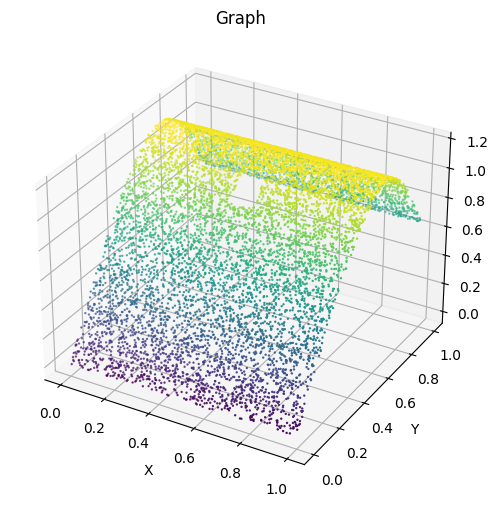

sum error: 0.0


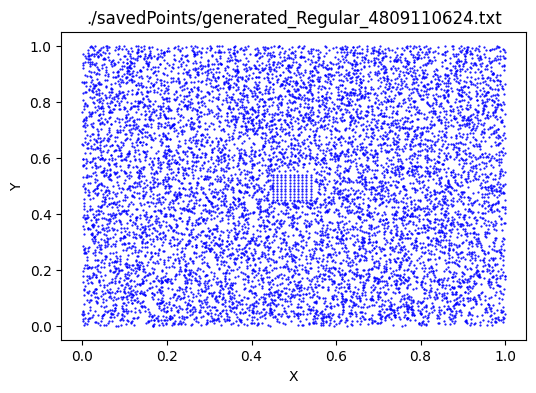

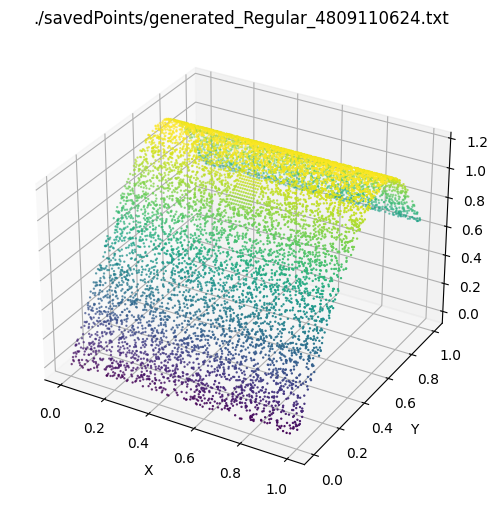

sum error: 0.11027830450250842


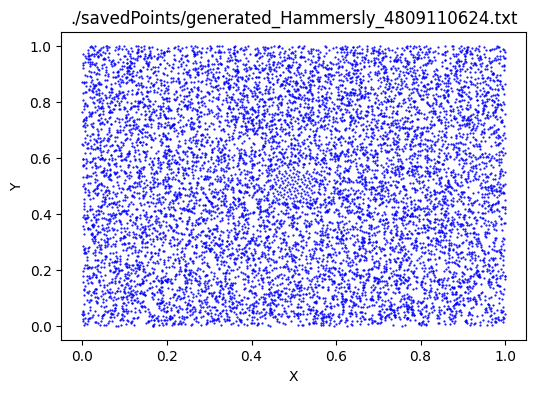

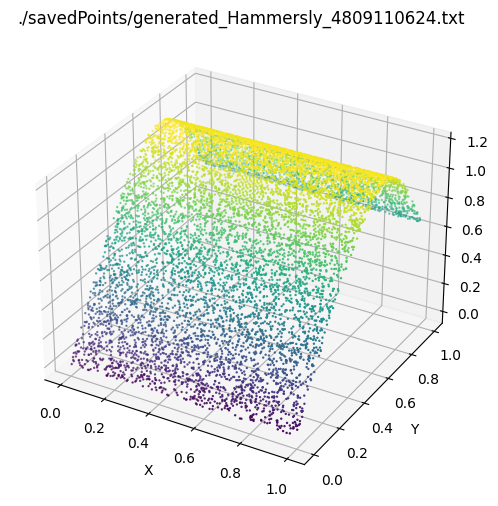

sum error: 0.11386627382719883


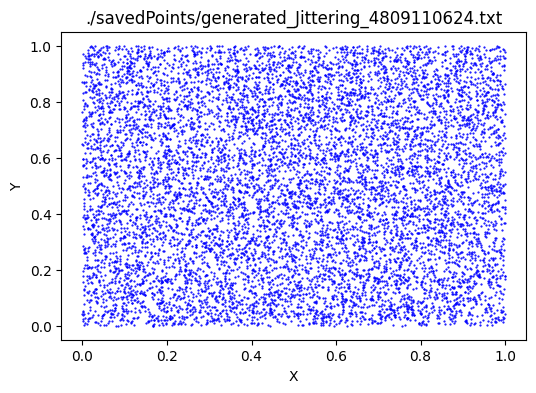

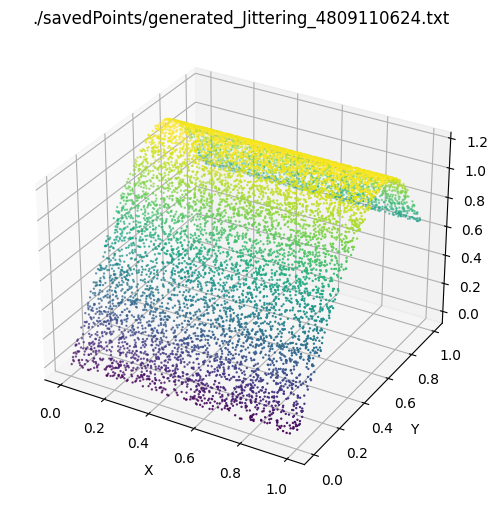

sum error: 0.1209388403392404


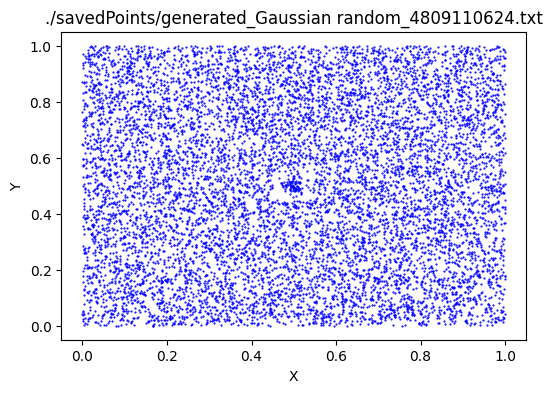

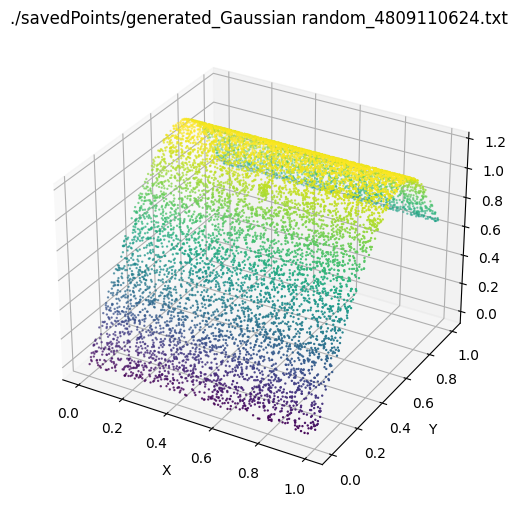

sum error: 0.12673802957576005


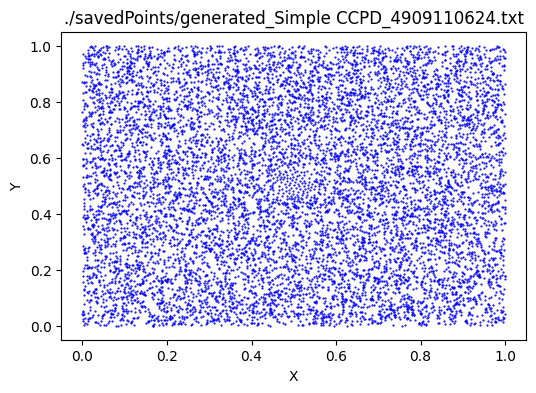

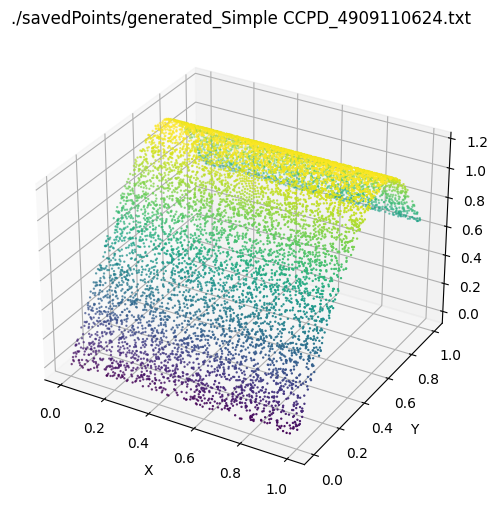

sum error: 0.11320281377573282


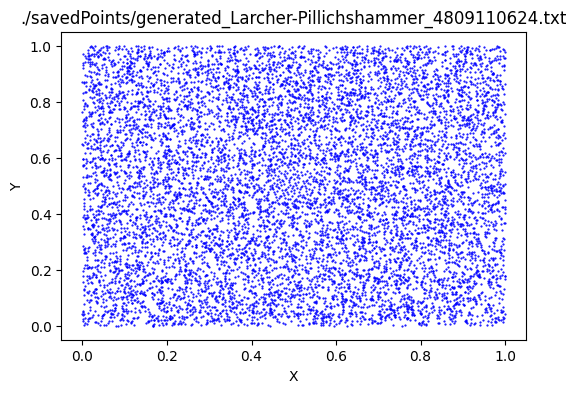

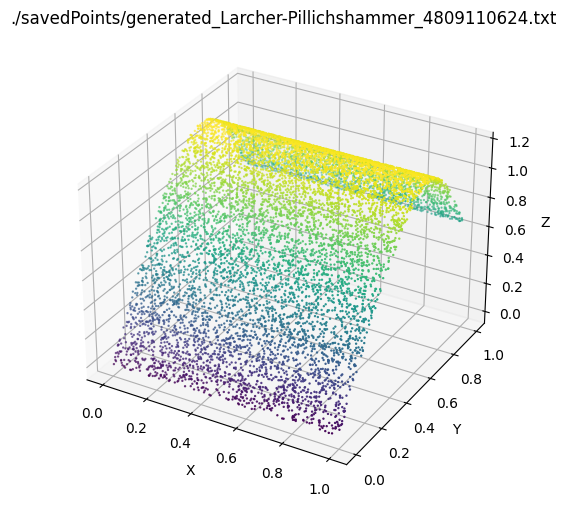

sum error: 0.11371527450045116


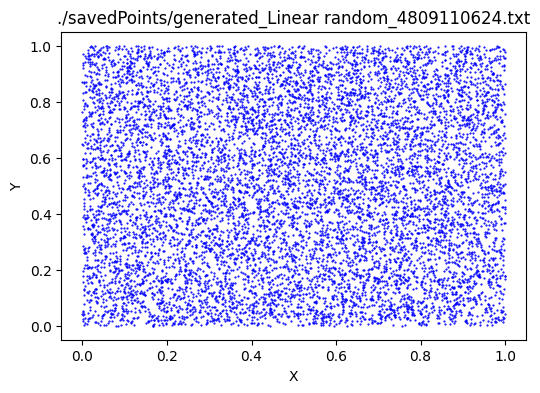

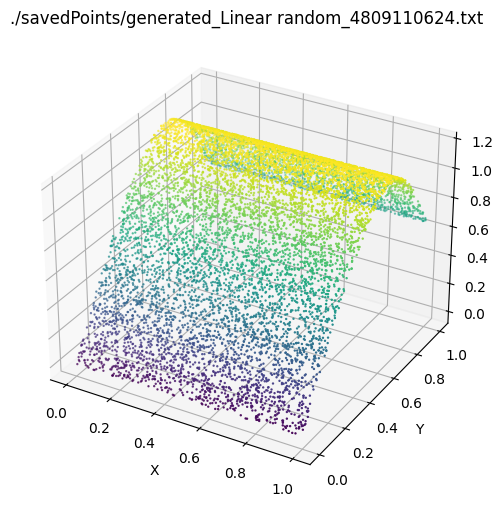

sum error: 0.10492064784344912


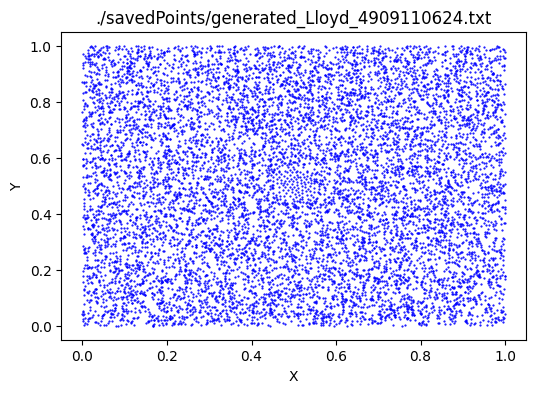

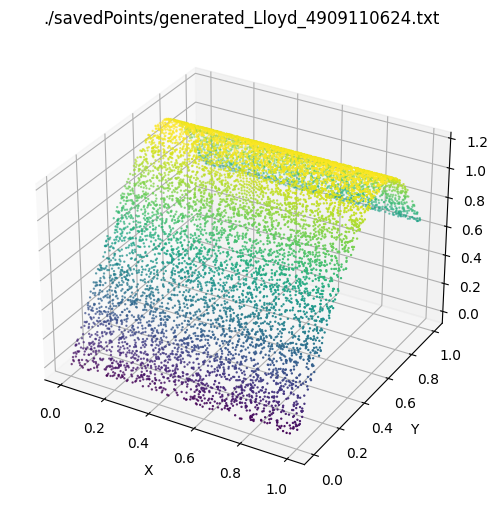

sum error: 0.10225920920907339


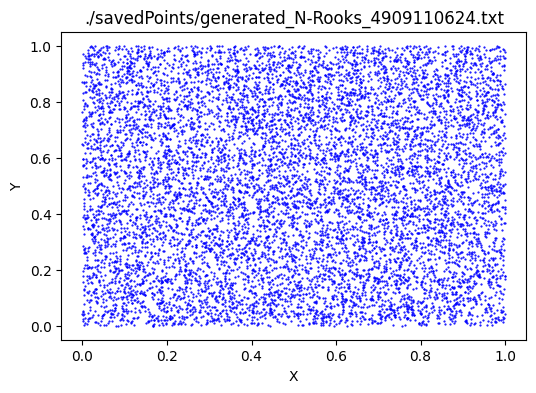

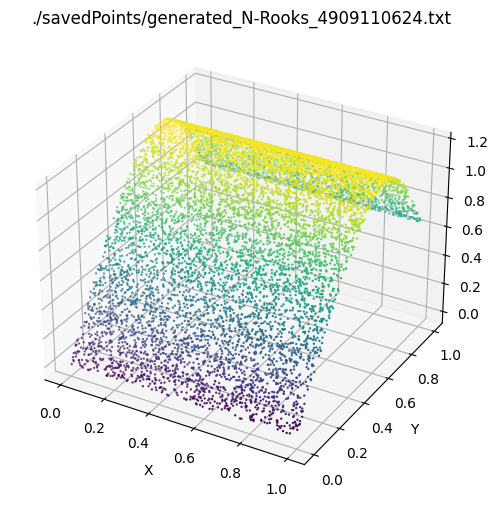

sum error: 0.12152342587462517


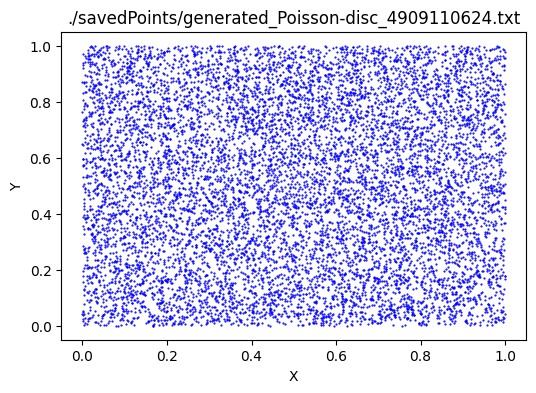

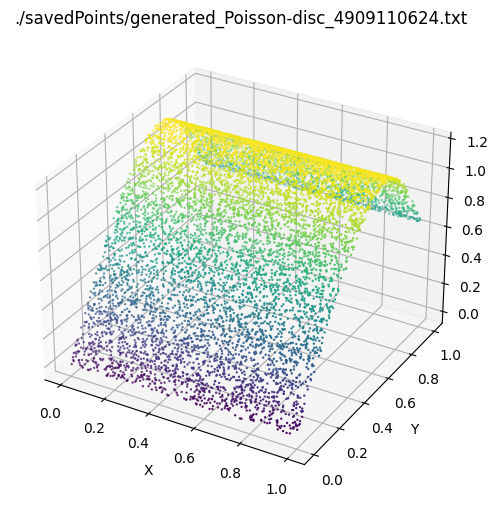

sum error: 0.11292945776240015


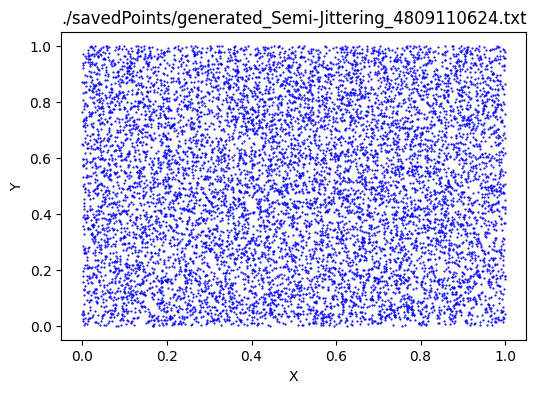

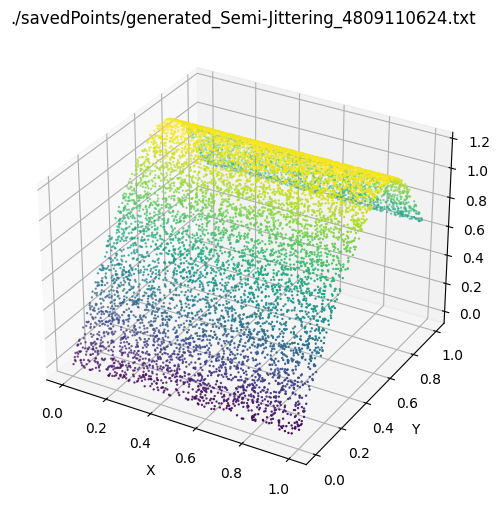

sum error: 0.1182809890055555


In [6]:
import math
def calculateError(point):
    x = point[0]
    y = point[1]
    z = point[2]
    a = pow(y,4)
    a += math.sin(y*2.5+a)
    return np.abs(z-a)

startPoints = load("../Diplomka/SOLUTION/custom4.txt")
show(startPoints)
sumErr = 0
for p in startPoints:
    sumErr += calculateError(p)
print(f"sum error: {sumErr}")


inputFiles = ["./savedPoints/generated_Regular_4809110624.txt", 
              "./savedPoints/generated_Hammersly_4809110624.txt", 
              "./savedPoints/generated_Jittering_4809110624.txt",
              "./savedPoints/generated_Gaussian random_4809110624.txt",
              "./savedPoints/generated_Simple CCPD_4909110624.txt",
              "./savedPoints/generated_Larcher-Pillichshammer_4809110624.txt",
              "./savedPoints/generated_Linear random_4809110624.txt",
              "./savedPoints/generated_Lloyd_4909110624.txt",
              "./savedPoints/generated_N-Rooks_4909110624.txt",
              "./savedPoints/generated_Poisson-disc_4909110624.txt",
              "./savedPoints/generated_Semi-Jittering_4809110624.txt"]
#inputFiles = ["./savedPoints/generated_Regular_4809110624.txt"]
filePoints = []
for fileName in inputFiles:
    pointsFromFile = load_2d(fileName)
    filePoints.append(pointsFromFile)
    #showAndAdd_2d(points,pointsFromFile,figsize=(16,12), title=fileName)
    #pts = points+pointsFromFile
    #triangulate(pts,figsize=(16,12),title="triangles - {}".format(fileName))
    #mergeWithHole(filePoints)

counter = 0
for setOfPoints in filePoints:
    mergedPoints = mergeWithHole([setOfPoints], inputFiles[counter])
    sumErr = 0
    for p in mergedPoints:
        sumErr += calculateError(p)
    print(f"sum error: {sumErr}")
    counter+=1

    